### Deadline

Wednesday, November 22, 2017, 11:59PM

### Important notes

When you push your Notebook to GitHub, all the cells must already have been evaluated.
Don't forget to add a textual description of your thought process and of any assumptions you've made.
Please write all your comments in English, and use meaningful variable names in your code.
Question 1: Propensity score matching

In this exercise, you will apply propensity score matching, which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "Evaluating the Econometric Evaluations of Training Programs" (1986). The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program. Your task is to determine the effectiveness of the "treatment" represented by the job training program.

### Dataset description

treat: 1 if the subject participated in the job training program, 0 otherwise
age: the subject's age
educ: years of education
race: categorical variable with three possible values: Black, Hispanic, or White
married: 1 if the subject was married at the time of the training program, 0 otherwise
nodegree: 1 if the subject has earned no school degree, 0 otherwise
re74: real earnings in 1974 (pre-treatment)
re75: real earnings in 1975 (pre-treatment)
re78: real earnings in 1978 (outcome)
If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the "Design of Observational Studies". Even just reading the first chapter (18 pages) will help you a lot.

In [1]:
import pandas as pd
import os
import numpy as np

from sklearn.metrics import  confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
import seaborn as sns


In [4]:
# load data
data_raw = pd.read_csv('lalonde.csv')
data_raw.head(3)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.046
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.894
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.450


#### 1. A naive analysis :

Compare the distribution of the outcome variable (re78) between the two groups, using plots and numbers. To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").
What might a naive "researcher" conclude from this superficial analysis?

In order to examine these two distributions, we will compare their boxplots and histograms.

In [5]:
def compare_feature(data, feature_name):
    
    # separate data
    control = data[data['treat']==0]
    treat = data[data['treat']==1]  
    data_feature = data[[feature_name]]
    control_feature = control[[feature_name]]
    treat_feature = treat[[feature_name]]
    
    # add boxplot if data is non-binary
    if not ((data[feature_name]==0) | (data[feature_name]==1)).all():
        fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True);
        control_feature.boxplot(ax=axes[0])
        axes[0].set_title('Control')
        treat_feature.boxplot(ax=axes[1])
        axes[1].set_title('Treated')
    
    # plot histograms
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True);
    control_feature.plot.hist(ax=axes[0],title='Control - ' + feature_name)
    treat_feature.plot.hist(ax=axes[1],title='Treated - ' + feature_name)

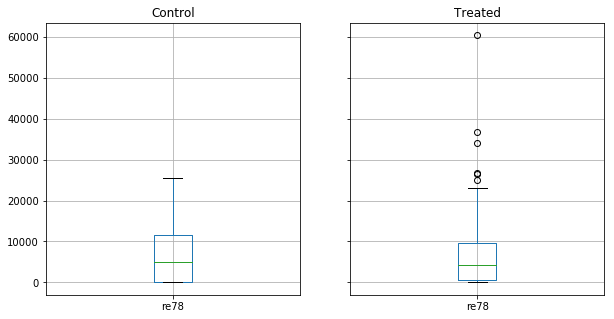

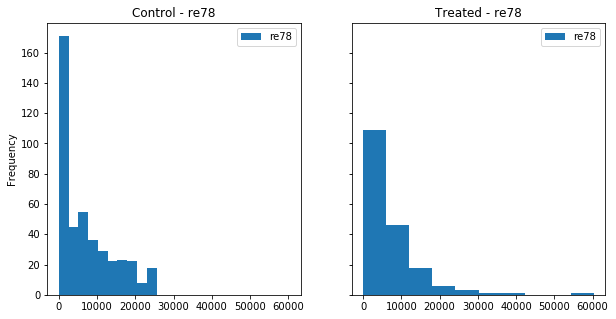

In [6]:
compare_feature(data_raw, 're78')

We can see that there are a lot more unemployed (re=0) subjects in the control group then in the test group. Apart from this fact and ignoring the outliers in the test group, there is no substancial difference in revenue between both groups. Therefore the job training program reduces the likelyhood of being unemployed but does not, on average, affect revenue.

#### 2. A closer look at the data:
You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above. You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.
For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers. As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.
What do you observe? Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

We can similarly display and compare the distributions for all features of our dataset.

In [7]:
def display_features_comparison(data,skip_features=[]):
    feature_names = data.columns[2:]

    # for all features
    for feature_name in feature_names:
        if feature_name not in skip_features:
            compare_feature(data,feature_name)

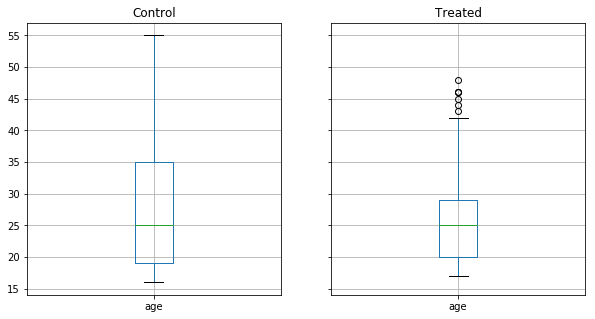

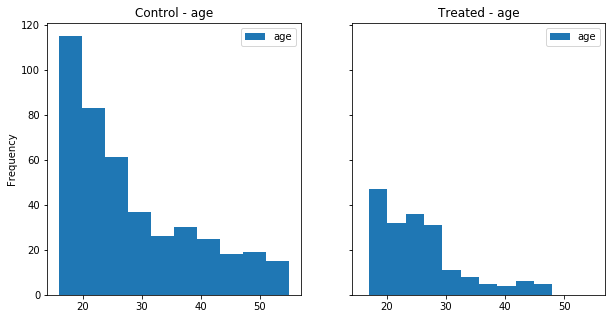

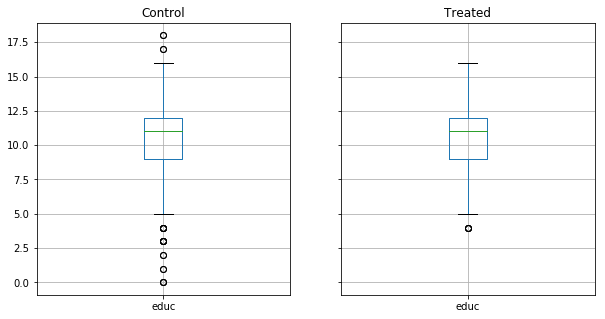

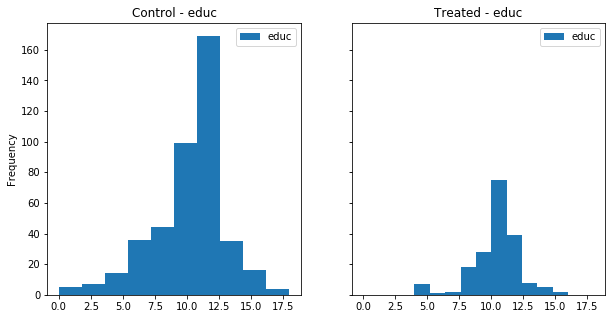

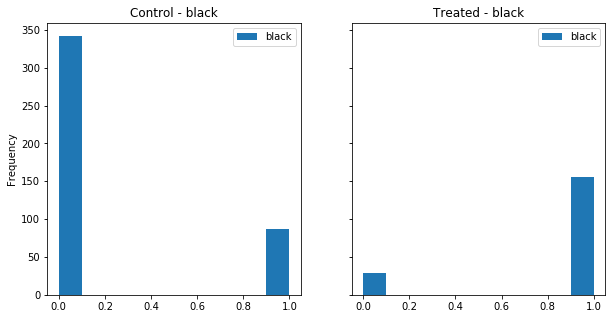

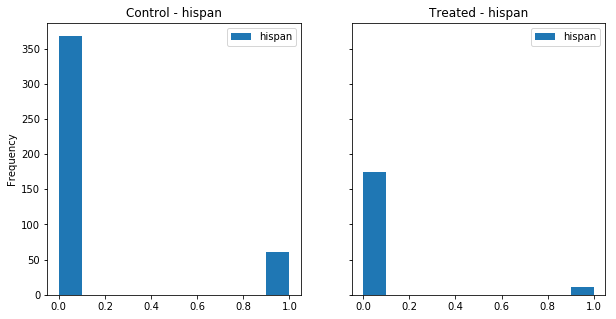

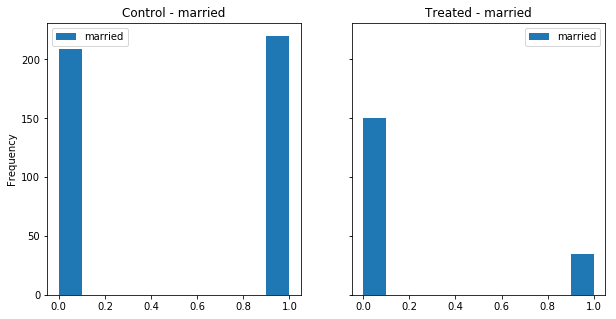

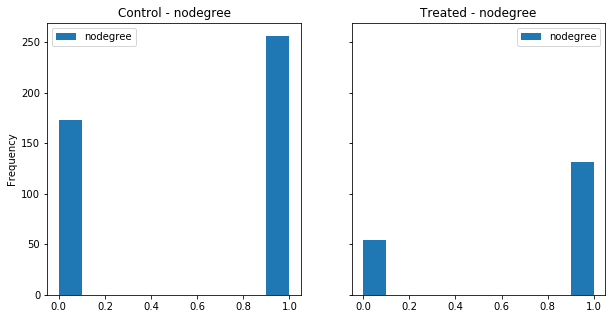

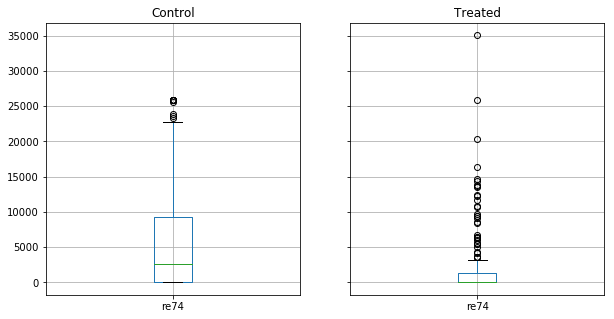

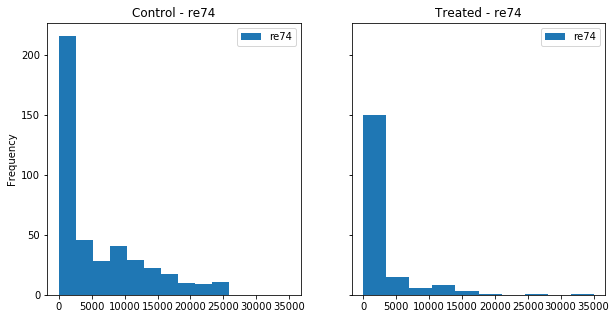

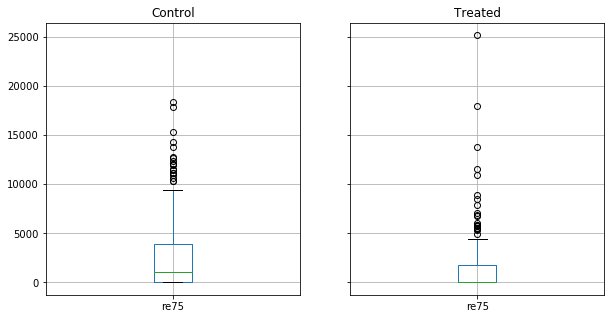

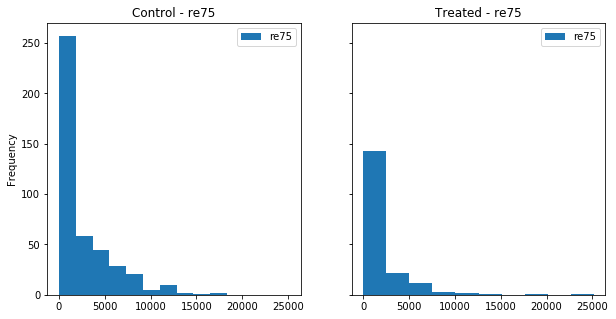

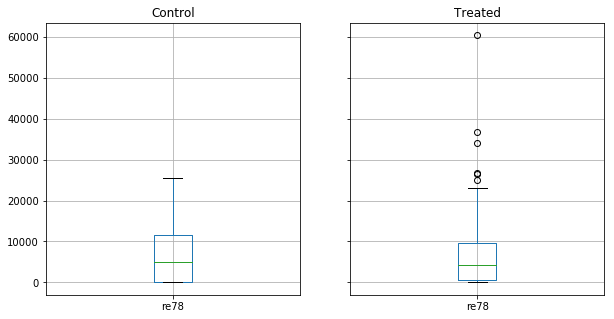

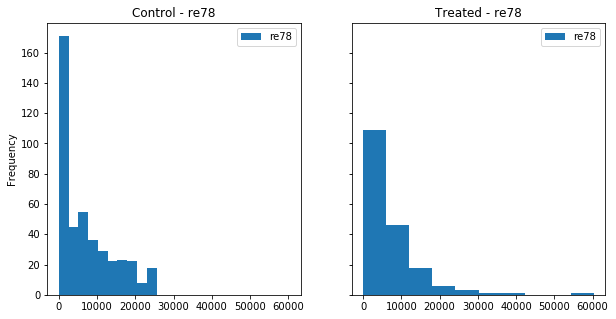

In [8]:
display_features_comparison(data_raw)

Based on these plots we can point out several problems with the reasoning of the naive "researcher". First of all, both groups are not balanced with each other. They do not have the same number of subjects (429 to 185), and many features that could affect revenue (black,hispan,married,nodegree) are not represented in the same proportions. Moreover, we can see that there was actually a big difference in revenue before the training (re74 and re75) between both groups, with the test group being a lot more unemployed/poor in comparison with the control group. Setting aside the fact that both groups are unbalanced, we would conclude that the test group of "poor" subjects became as wealthy as the control group after the training, i.e., that the training was very effective. However we can also note that there are many outliers in the boxplots for re74 and re75, suggesting that there are significant divergences within the test group.

#### 3. A propensity score model :
Use logistic regression to estimate propensity scores for all points in the dataset. You may use sklearn to fit the logistic regression model and apply it to each data point to obtain propensity scores:
from sklearn import linear_model logistic = linear_model.LogisticRegression() Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.). To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or this article.
Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups. (See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores. If you want even more information, read this article.)

In [9]:
# get training data
class_name = 'treat'
feature_names = data_raw.columns[2:]
X = data_raw[feature_names]
y = data_raw[class_name]

# fit model
logistic = LogisticRegression()
logistic.fit(X, y)

# predict and get propensity scores on training data
pred = logistic.predict_proba(X)
y_pred = logistic.predict(X)

In order to visualize the efficiency of our model, we will use a binary confusion matrix. Such a matrix can be plotted by using the function provided by [Matt Hancock](http://notmatthancock.github.io/2015/10/28/confusion-matrix.html).

In [10]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

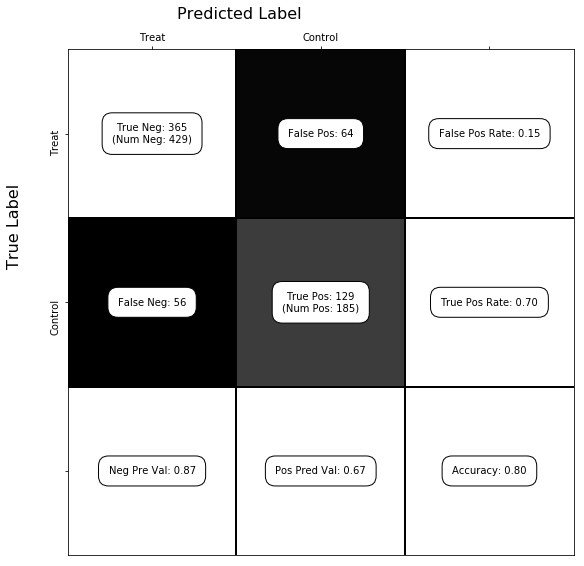

In [12]:
C = confusion_matrix(y,y_pred)
show_confusion_matrix(C,class_labels=['Treat','Control'])

#### 4. Balancing the dataset via matching:

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group. (Hint: you may explore the networkx package in Python for predefined matching functions).
Your matching should maximize the similarity between matched subjects, as captured by their propensity scores. In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.
After matching, you have as many treated as you have control subjects. Compare the outcomes (re78) between the two groups (treated and control).
Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects. What do you observe? Are you closer to being able to draw valid conclusions now than you were before?

In order to perform our matching, we will start off by defining a (euclidean) distance matrix where each element is the euclidean distance between the propensity score vectors of a test subject *i* with a control subject *j*. Using this matrix, matching each test subject to his control alter ego is equivalent to solving a classical [assignment problem](https://en.wikipedia.org/wiki/Assignment_problem). This problem can be solved with the scipy.optimize.linear_sum_assignment function which uses the [Hungarian Algorithm](https://en.wikipedia.org/wiki/Hungarian_algorithm), also known as the Munkres or Kuhn-Munkres algorithm.

In [13]:
def get_matching_indices(data,class_name, feature_names):
    
    # fit logistical model
    X = data[feature_names]
    y = data[class_name]
    logistic = LogisticRegression()
    logistic.fit(X, y)
    
    # predict on classes separatly
    control = data[data[class_name]==0]
    treat = data[data[class_name]==1]
    X_control = control[feature_names]
    pred_control = logistic.predict_proba(X_control)
    X_treat = treat[feature_names]
    pred_treat = logistic.predict_proba(X_treat)
    
    # Hungarian matching algorithm
    dist_matrix = cdist( pred_treat, pred_control )
    treat_index, control_index = linear_sum_assignment(dist_matrix)
    
    # Map matrix index back to sample index
    control_id = control['id'].reset_index(drop=True)
    treat_id = treat['id']
    treat_id_sample = treat_id.iloc[treat_index]
    control_id_sample = control_id.iloc[control_index].reset_index(drop=True)
    return treat_id_sample.append(control_id_sample).reset_index(drop=True)
    

In [14]:
sample_id = get_matching_indices(data=data_raw,
                                 class_name='treat',
                                 feature_names=data_raw.columns[2:])
data_sample = data_raw[data_raw['id'].isin(sample_id)]

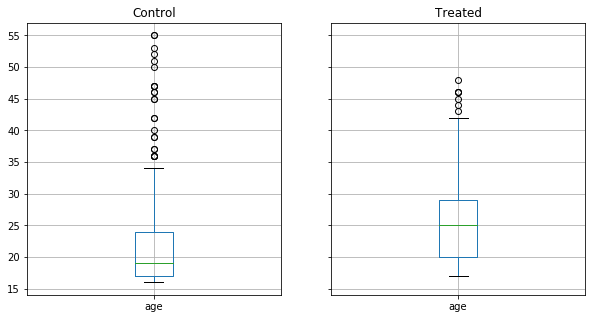

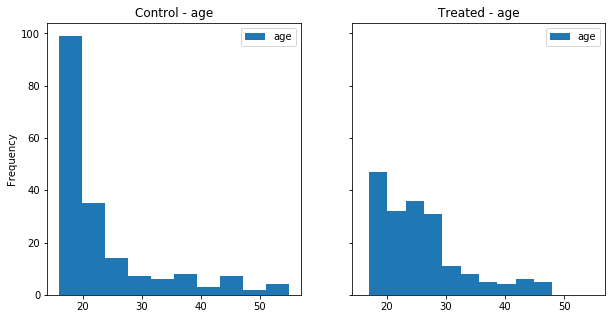

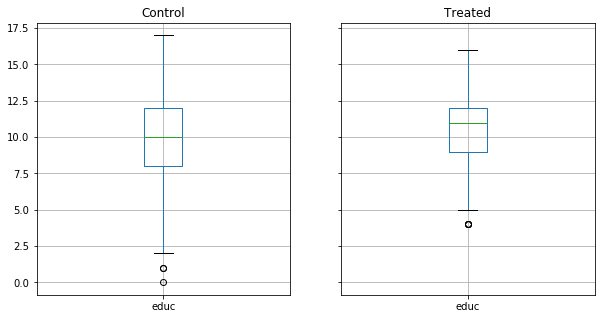

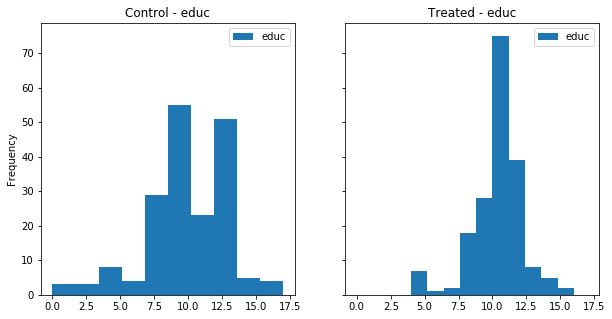

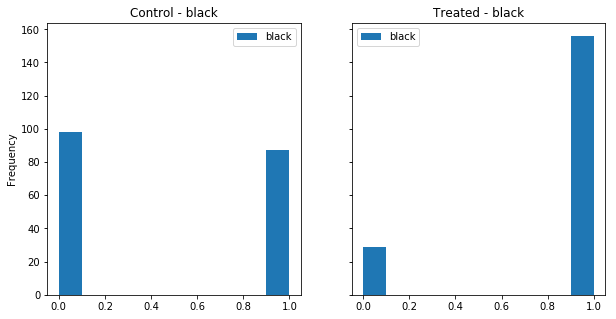

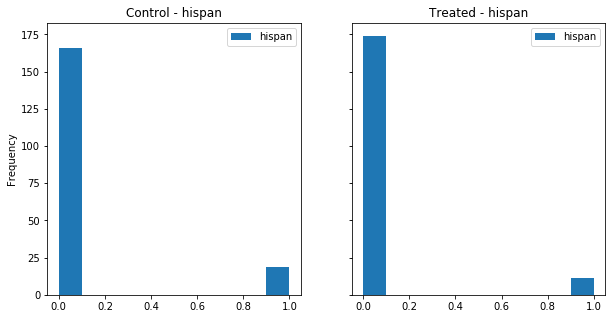

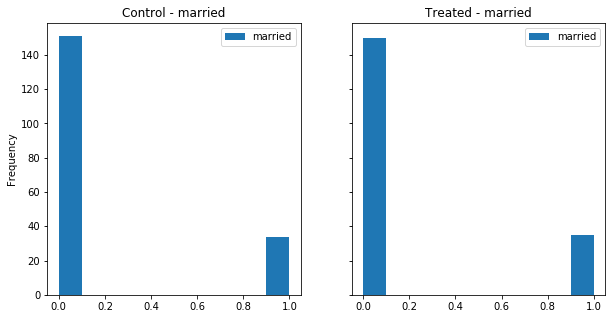

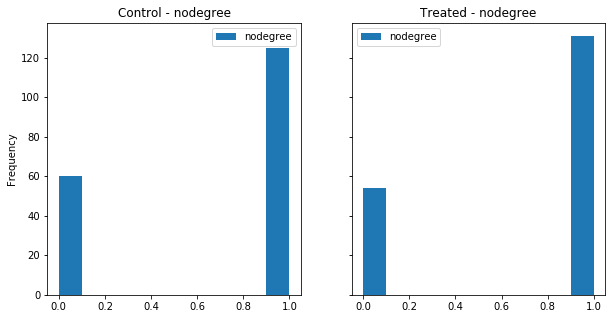

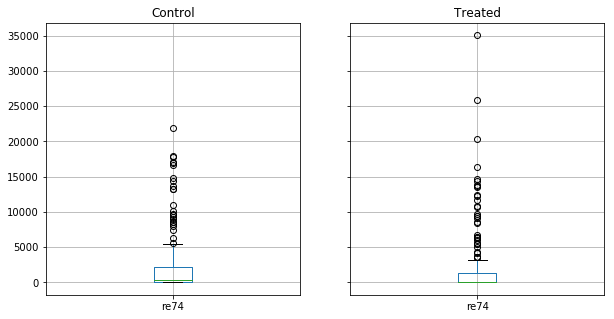

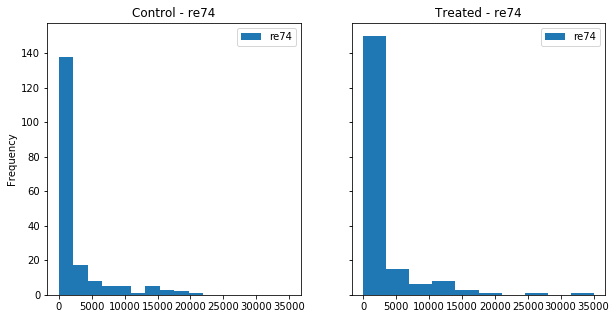

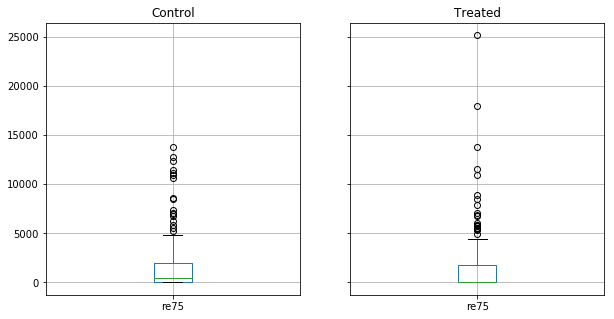

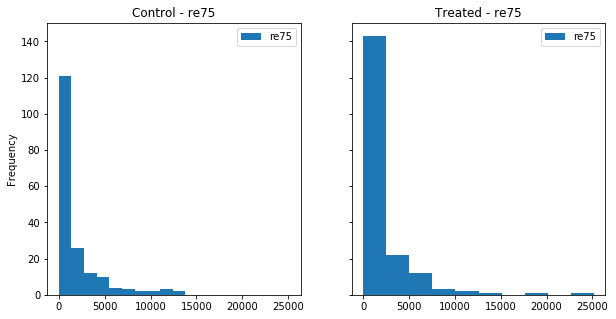

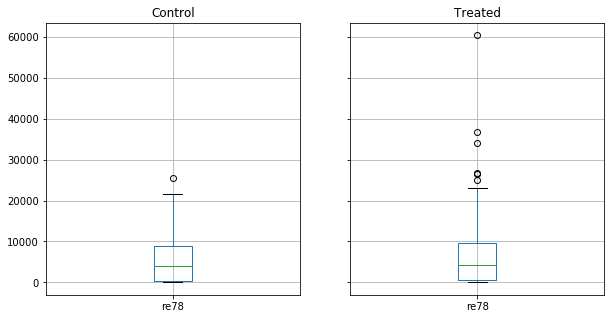

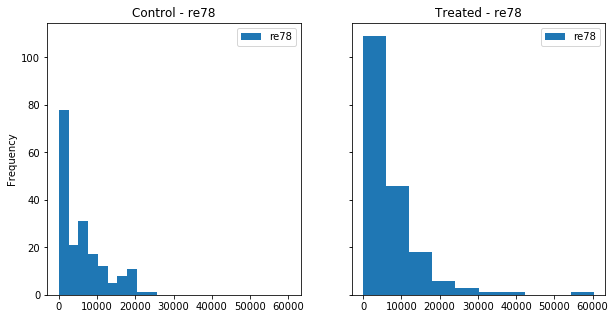

In [15]:
display_features_comparison(data_sample)

We can now see that many of the previously unbalanced features (hispan,married,nodegree) have been balanced out by our matching algorithm. These features did have a significant impact on revenue since our new control group now has a similar re74 and re75 to our test group. However this new result invalidates our previous conclusion : since both the test and the control group saw an increase in revenue between 1975 and 1978, we are now less certain about the efficacy of the job training program. On average, the re78 is higher for the test group, but not significantly enough to conclude that the job training program is actually useful.

#### 5. Balancing the groups further
Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching? Would you say your dataset is sufficiently balanced? If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?
Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature. Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

There is still one feature that is still not balanced between both groups : black, which may be one of the most important factors when it comes to [income inequality in the United States](https://en.wikipedia.org/wiki/Racial_wage_gap_in_the_United_States). Furthermore, the boxplots for re74, re75 and re78 still have many outliers, suggesting that there is a division within our dataset. In order to verify our concerns, we will redo our matching/comparison on separate datasets for blacks and non-blacks.


For blacks :

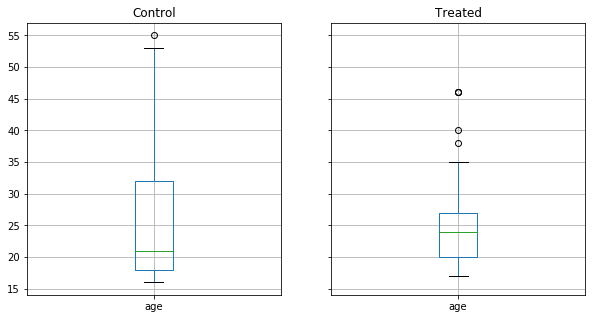

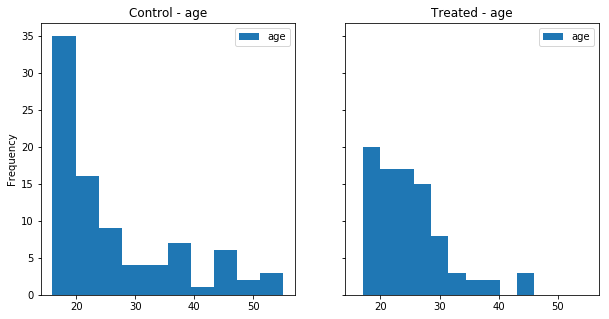

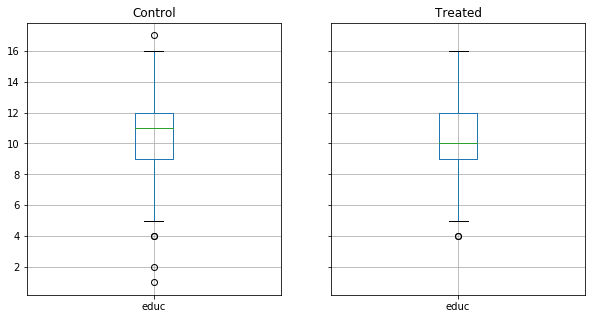

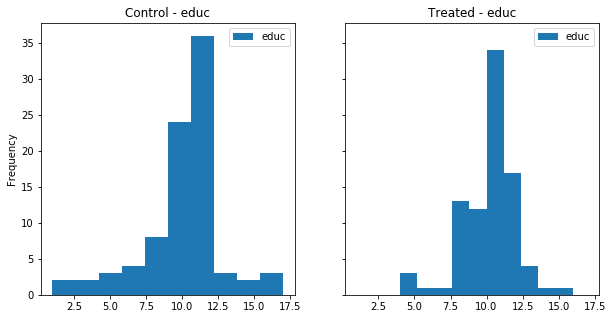

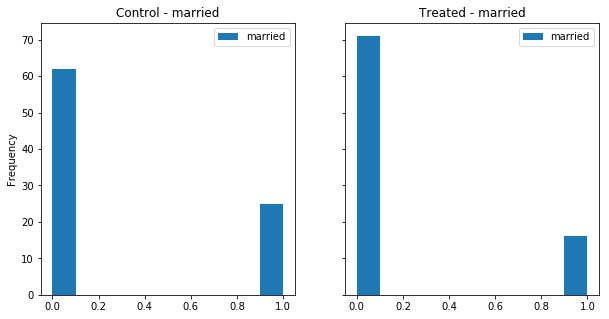

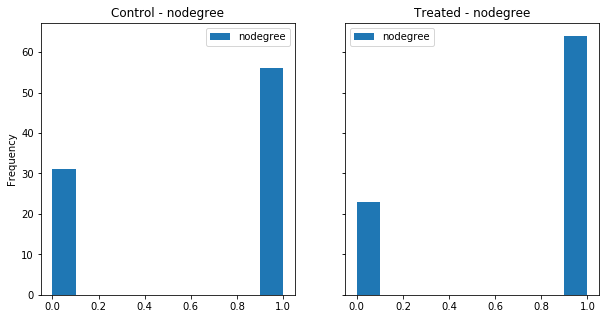

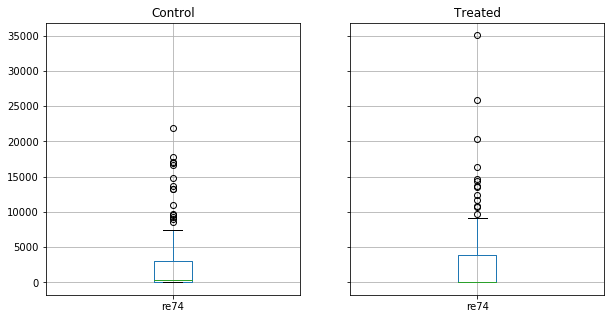

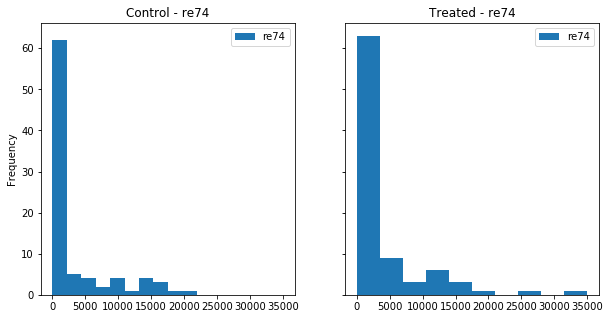

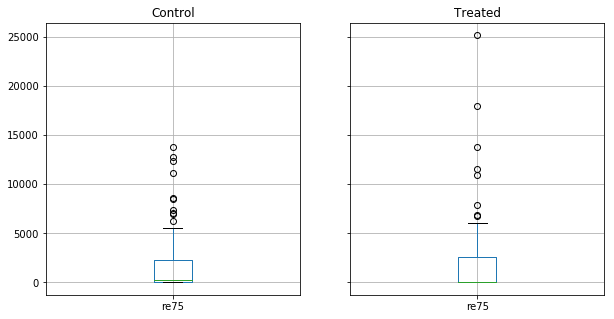

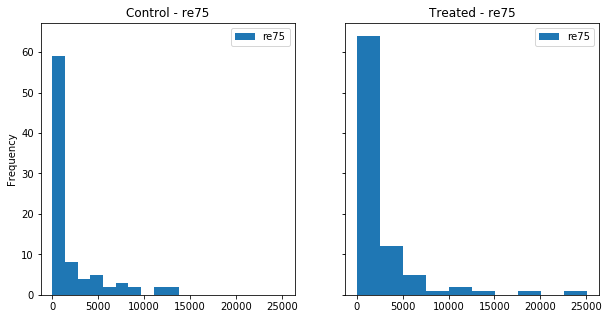

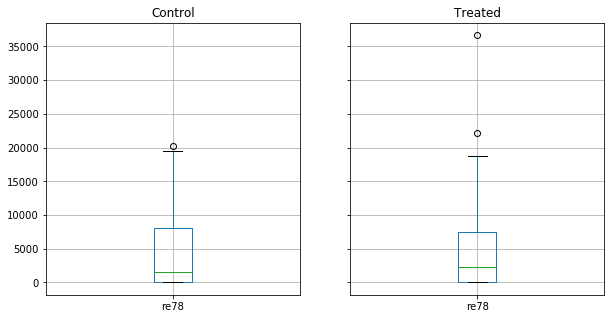

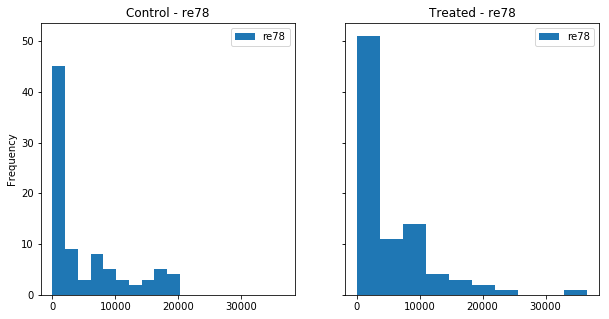

In [16]:
data_black = data_raw[data_raw['black']==1]
names_of_features = data_raw.columns[2:].tolist()
names_of_features.remove('black')
names_of_features.remove('hispan')

sample_id = get_matching_indices(data=data_black,
                                 class_name='treat',
                                 feature_names=names_of_features)
data_sample_black = data_black[data_black['id'].isin(sample_id)]
display_features_comparison(data_sample_black,skip_features=['hispan','black'])

For non-blacks :

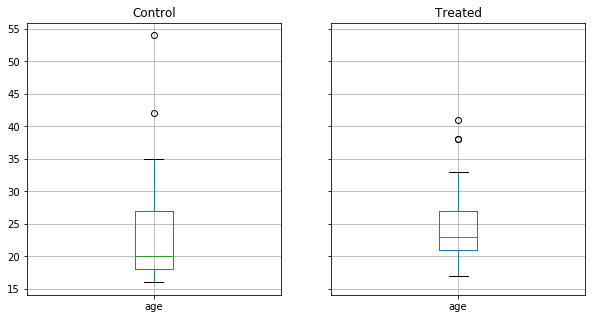

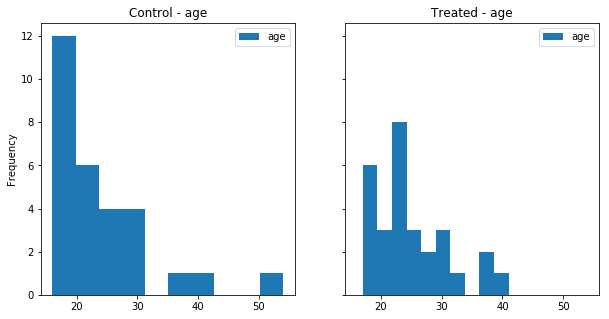

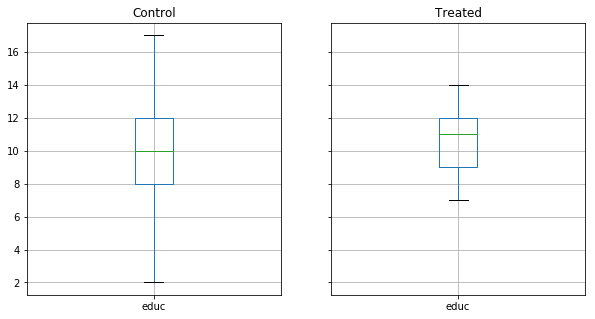

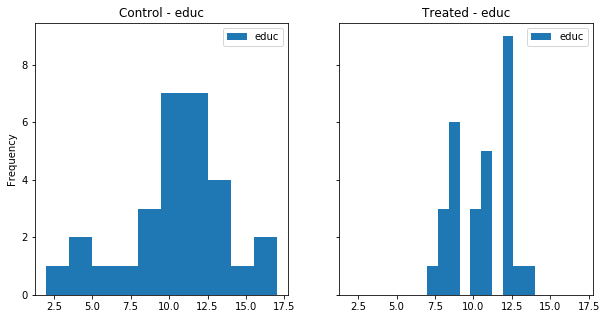

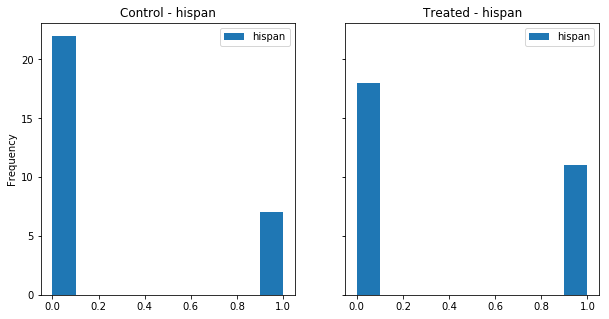

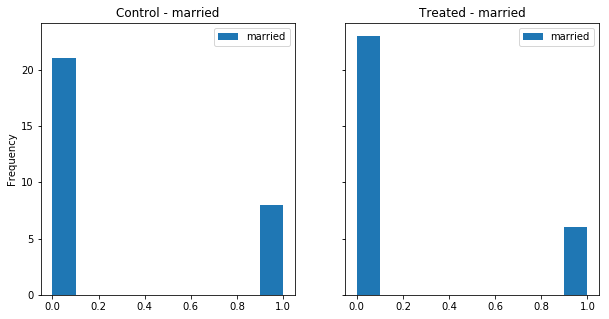

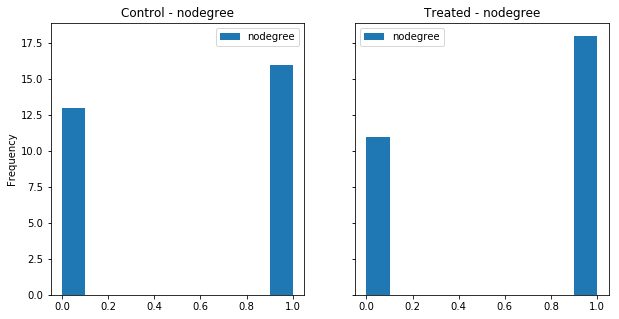

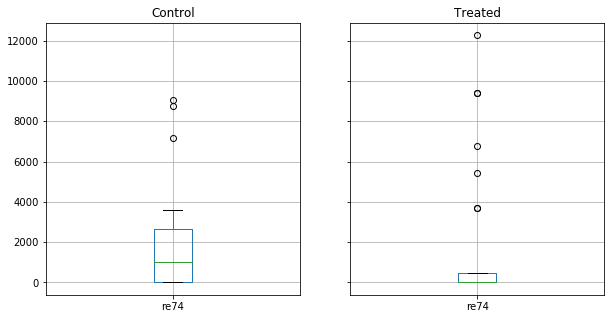

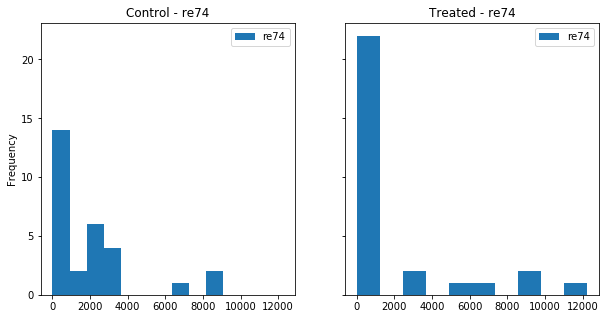

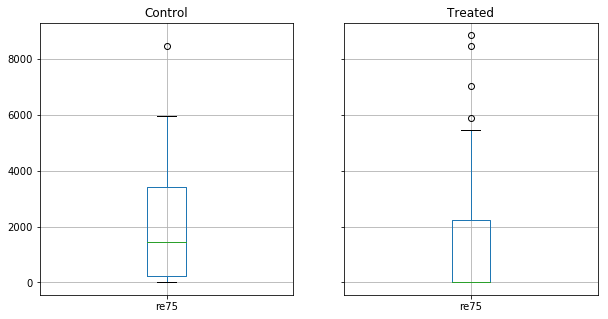

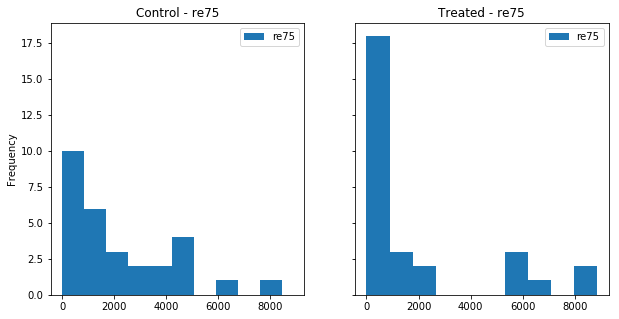

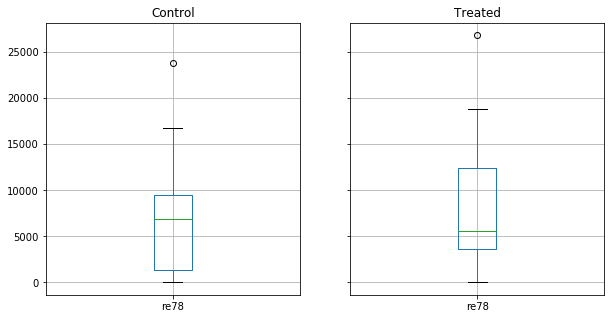

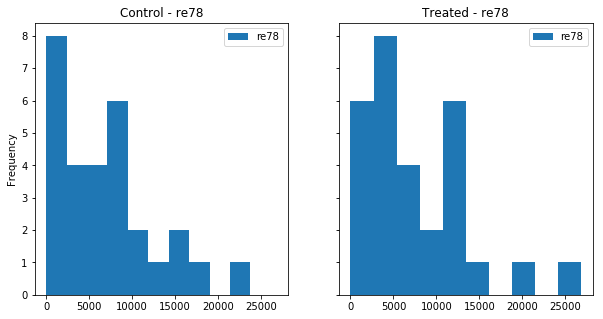

In [17]:
data_no_black = data_raw[data_raw['black']==0]
names_of_features = data_raw.columns[2:].tolist()
names_of_features.remove('black')

sample_id = get_matching_indices(data=data_no_black,
                                 class_name='treat',
                                 feature_names=names_of_features)
data_sample_no_black = data_no_black[data_no_black['id'].isin(sample_id)]
display_features_comparison(data_sample_no_black,skip_features=['black'])

We can see that there are indeed large discrepencies between the revenues of both subgroups. We will therefore draw different conclusions for both groups : 

- For blacks, the feature distributions for both control and test groups are quite close which allow us to draw strong conclusions. Compared to non-blacks, blacks are much more likely to be unemployed and on average earn much less, though there are many exceptions to this rule (many outliers in boxplots). When comparing re74, re75, and re78, we can observe that the revenue of both groups has grown almost identically. We can therefore conclude that for blacks, the job training program had no effect.


- For non-blacks, there are still discrepencies between the feature distributions for both control and test groups, meaning that any conclusion made from these results must be taken with a grain of salt. If we were to only look at the re74 and re78, we would deduce that the more unemployed/poor test groups in 1974 has caught up in terms of wealth by 1978 with the control group, i.e., that the training program has been highly efficient. However, for strange reasons, there is a high disparity between the re74 and re75 for both the control and the test group. Because of these inconsistencies, it is not possible for us to conclude that the training program was actually successful.

#### Possible external factors :

The inconsistencies in our results may have been caused by factors that have not been taken into account by our dataset. These factors could include macroeconomic trends that occured during the study. Ideally, the study should have been conducted over a period of stable growth/unemployment. This, however, was not the case. After the 1973 oil crisis, the United States entered a period of [recession](https://en.wikipedia.org/wiki/1973%E2%80%9375_recession) between 1973 and 1975, which caused wages to drop and unemployement to rise. This was when the values for revenue before the job training program were reported. The US would only fully recover in 1978, when economic growth would peak at 5.6% (fig:1). This was when the values for revenue after the job training program were reported. Given such drastic changes in the economy, and based on the evolution of wages coupled with inflation during the period of the study (fig:2 and 3), it is not possible to draw conclusions from this study (payment is required to get data for wages and inflation, therefore you will need to indulge our PNGs ;) ).

Get GDP values :

In [2]:
gdp = pd.read_csv('real_gdp_rate_1972_to_1980.csv')
gdp = gdp.set_index('DATE', drop=True)
gdp_values = gdp.values.flatten().tolist()
gdp_dates = gdp.index.values

Get Unemployment values :

In [3]:
unemployment = pd.read_excel('unemployment_1972_to_1980.xlsx',skiprows=[0,1,2,3,4,5,6,7,8,9])
unemployment = unemployment.rename(columns=unemployment.iloc[0])
unemployment = unemployment.drop(unemployment.index[0])
unemployment = unemployment.stack()

unemployment_values = []
for i in range(1,9):
    unemployment_values.extend(unemployment[i].values[1:].tolist())

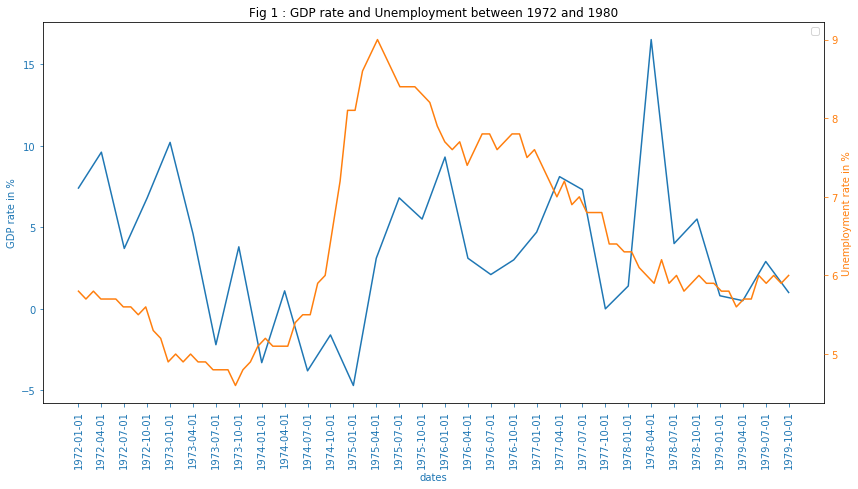

In [4]:
fig=plt.figure(figsize=(14,7))
ax=fig.add_subplot(111, label="GDP")
ax2=fig.add_subplot(111, label="Unemployment", frame_on=False)

ax.plot(gdp_dates,gdp_values, color="C0")
ax.set_xlabel("dates", color="C0")
ax.set_ylabel("GDP rate in %", color="C0")
ax.tick_params(axis='x', colors="C0", rotation=90)
ax.tick_params(axis='y', colors="C0")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])

ax2.plot(unemployment_values, color="C1")
ax2.get_xaxis().set_visible(False)
ax2.yaxis.tick_right()
ax2.set_ylabel('Unemployment rate in %', color="C1")       
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='y', colors="C1")

plt.title('Fig 1 : GDP rate and Unemployment between 1972 and 1980')
plt.show()

Fig 2 :

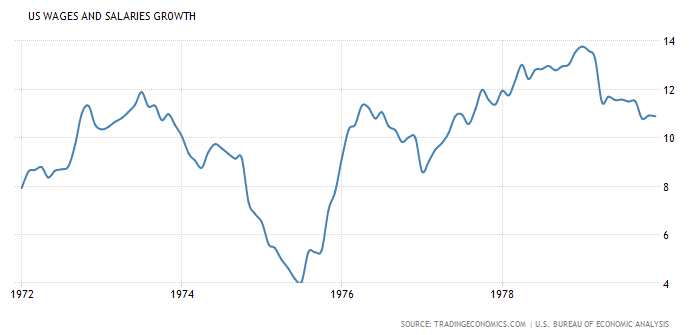

In [21]:
Image("wages_1972_to_1980.PNG",width=800)

Fig 3 :

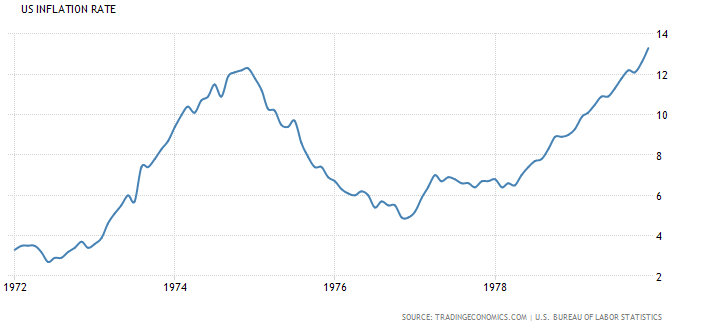

In [22]:
Image("inflation_1972_to_1980.PNG",width=800)

## Question 2: Applied ML

We firstly need to load the dataset and extract the TF-IDF features from it. We decided to remove the stopwords from the TF-IDF computation in order to obtain more meaningful features. We also displayed the number of documents contained in each category to check if all of them are balanced. They are more or less equal excepting concerning the Middle-East which has 40% more articles than the other categories.

In [19]:
#The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents here exactly 18846
#130 107 terms

#import data
newsgroups = fetch_20newsgroups(subset='all',shuffle=True)
#Transform with TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
vectors_all = vectorizer.fit_transform(newsgroups.data)
target_all= newsgroups.target

nb_docs=vectors_all.shape[0]
nb_terms=vectors_all.shape[1]

18846
173451


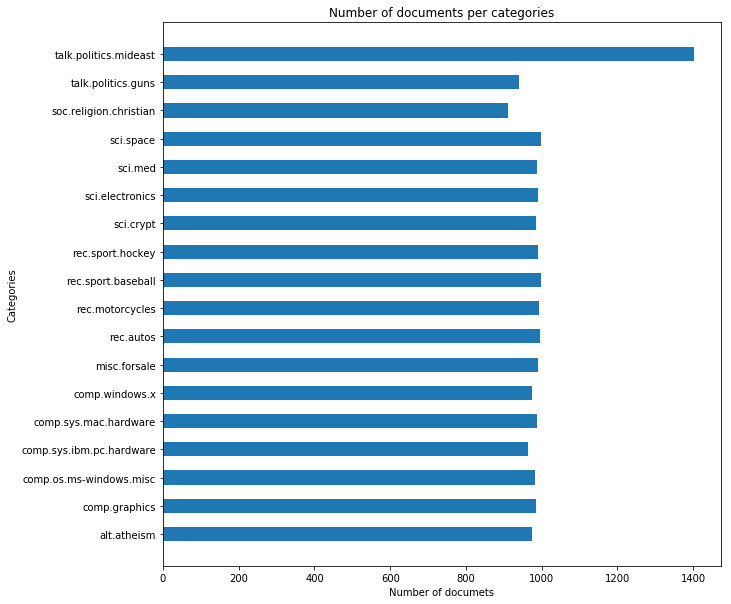

In [20]:
labels =newsgroups.target_names
plt.figure(figsize=(10,10)) 
plt.hist(target_all, bins = np.arange(1,20),orientation="horizontal",rwidth=0.5) 
plt.title("Number of documents per categories")
plt.ylabel("Categories")
plt.yticks(np.arange(1.5,19.5) ,labels, rotation='horizontal')
plt.xlabel("Number of documets")
plt.show()

We can know split our data into training, validation and test sets. The training set is used to train all the models with a grid search algorithm,  the validation set is used to find the optimal hyperparameters for the model and the test set is used to assess the accuracy of the final model.

In [21]:
#select the document index for test, train and validation set

test_index=np.random.choice(nb_docs,np.round(nb_docs/10).astype(int))
valid_index=np.random.choice(np.setxor1d(np.arange(nb_docs),test_index),np.round(nb_docs/10).astype(int))
train_index=np.setxor1d(np.setxor1d(np.arange(nb_docs),test_index),valid_index)

In [22]:
vectors_train=vectors_all[train_index]
vectors_valid=vectors_all[valid_index]
vectors_test=vectors_all[test_index]

target_train=target_all[train_index]
target_valid=target_all[valid_index]
target_test=target_all[test_index]

del vectors_all
del target_all

We took the most relevant parameters (the maximum depth and the number of estimators) and we made a grid for different values of those hyperparameters on a logarithmic scale. After running this algorithm, we found out that the best values according to the ill-classified documents were 100 for the maximum depth and 1000 for the number of estimators. Of course we could find better parameters, but we decided that an accuracy of 85% is sufficient.

In [9]:
grid_max_depth=[1,10,100]
grid_nb_etimators=[1,10,100,1000]

diff=np.zeros((len(grid_max_depth),len(grid_nb_etimators),round(nb_docs/10)))

for i,max_depth in enumerate(grid_max_depth):
    for j,nb_estimators in enumerate(grid_nb_etimators):
        clf = RandomForestClassifier(n_estimators=nb_estimators,max_depth=max_depth)
        clf.fit(vectors_train,target_train)
        y_pred = clf.predict(vectors_valid)
        diff[i,j,:]=y_pred
        print('max_depth: '+str(max_depth)+' nb_estimators: '+str(nb_estimators)+' diff: ' +str(np.sum(np.not_equal(y_pred,target_valid))))


max_depth: 1 nb_estimators: 1 diff: 1774
max_depth: 1 nb_estimators: 10 diff: 1643
max_depth: 1 nb_estimators: 100 diff: 1235
max_depth: 1 nb_estimators: 1000 diff: 890
max_depth: 10 nb_estimators: 1 diff: 1611
max_depth: 10 nb_estimators: 10 diff: 1117
max_depth: 10 nb_estimators: 100 diff: 542
max_depth: 10 nb_estimators: 1000 diff: 437
max_depth: 100 nb_estimators: 1 diff: 1294
max_depth: 100 nb_estimators: 10 diff: 625
max_depth: 100 nb_estimators: 100 diff: 314
max_depth: 100 nb_estimators: 1000 diff: 265


We can know fit the model using the best hyperparameters, apply it on the test set and compute the normalized confusion matrix.

In [23]:
clf = RandomForestClassifier(n_estimators=1000,max_depth=100)
clf.fit(vectors_train,target_train)
y_test = clf.predict(vectors_test)

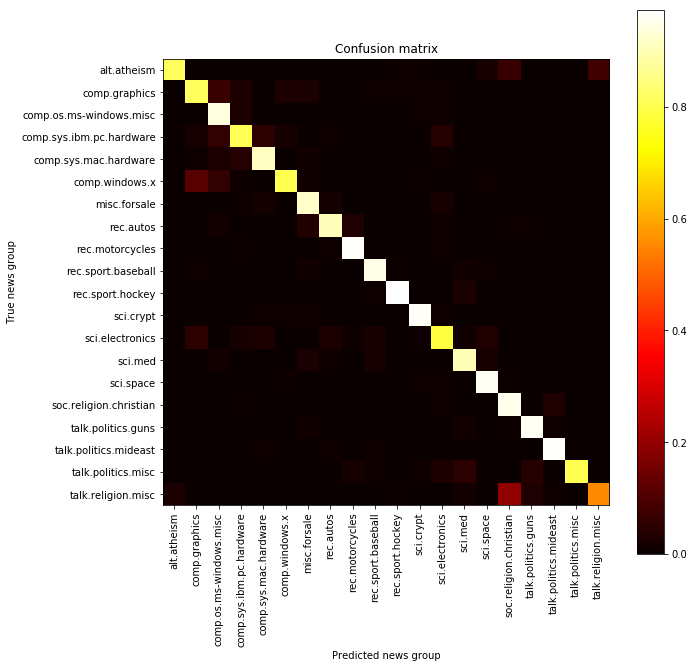

In [24]:

conf_mat=confusion_matrix(target_test,y_test)

target_names = newsgroups.target_names

plt.figure(figsize=(10,10))
plt.imshow(conf_mat/np.sum(conf_mat,axis=1),cmap=plt.cm.hot)
tick = np.arange(len(target_names))
plt.xticks(tick, target_names,rotation=90)
plt.yticks(tick, target_names)
plt.ylabel('True news group')
plt.xlabel('Predicted news group')
plt.title('Confusion matrix')
plt.colorbar()

We can see on this plot the confusion matrix, normalized by the number ot true-labelled news group. A few similar subjects (such as religion miscellaneous and religion christian) are more easily confused. On average, the 15% of ill-classified documents are well distributed between the different labels.

In [25]:
fimp=clf.feature_importances_


Text(0,0.5,'Words')

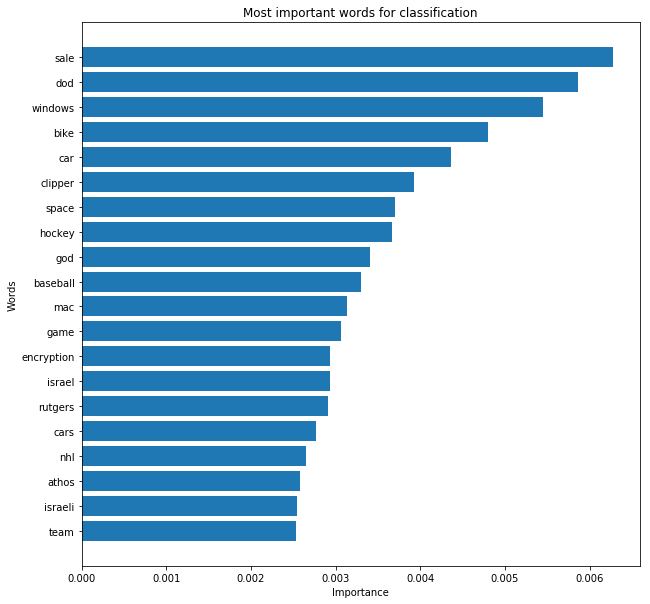

In [26]:
N_words=20
lkl=np.argsort(fimp)[-N_words::]
target_names=vectorizer.get_feature_names()
tick = np.arange(N_words)

plt.figure(figsize=(10,10))
plt.barh(np.arange(N_words), fimp[lkl])
plt.yticks(tick, [target_names[x] for x in lkl])
plt.title('Most important words for classification')
plt.xlabel('Importance')
plt.ylabel('Words')

We can examine the twenty terms that are most relevant in the classification.

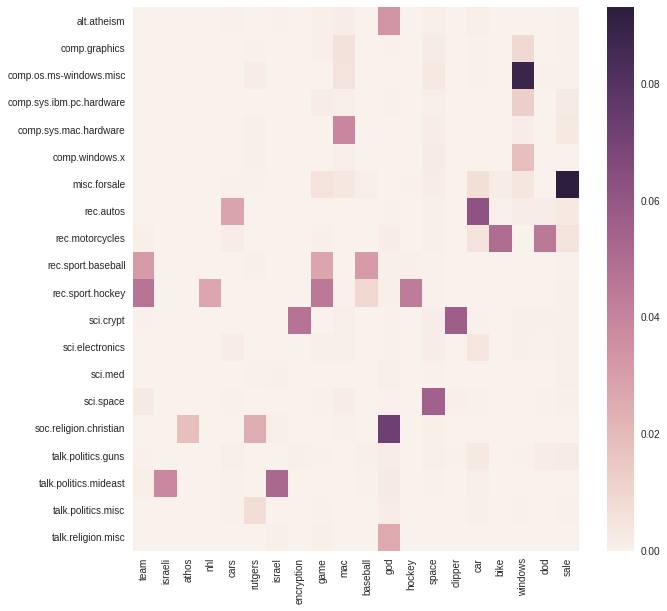

In [46]:
#Plot the mean tf-idf of the most important terms in each category
#find terms id  of the most important terms
terms_id=lkl

vec=np.zeros(max(target_train)+1)
tfsum=np.zeros((max(target_train)+1,len(terms_id)))

for i,cat in enumerate(target_train):
    vec[cat]=vec[cat]+1
    tfsum[cat,:]=tfsum[cat,:]+vectors_train[i,terms_id]

vec=tfsum/vec

#plot the category-term mean tf-idf as a heatmap
plt.figure(figsize=(10,10)) 
sns.heatmap(vec,xticklabels=[target_names[x] for x in lkl], yticklabels=newsgroups.target_names)

The above plot represents the average TF-IDF feature for each important term per category. Generally, we can see that the most relevant terms are the ones specific to a category (such as bike for motorcycle). For other terms such as "God" that are present in different categories, we need less important features to classify between the remaining categories. As displayed on the confusion matrix, accuracy has been lowered. 